# Dissertation Constituency Code

In [ ]:
%load_ext rpy2.ipython

%%R
sessionInfo()

## 1.Cleaning data

### Library Imports

In [ ]:
#Basics
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import openpyxl 
import re
#Difflib
from difflib import get_close_matches
from difflib import SequenceMatcher
#Shapely
from shapely.geometry import box
from shapely import wkt
import shapely.geometry
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import mapping
from shapely.geometry import shape
#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#Stats
from scipy import stats
import statsmodels.api as sm
from scipy.spatial import KDTree
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast
#Machine Learning
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
#GWR
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from scipy.spatial.distance import cdist
#Warning Supression
import warnings

- `MP_outside_earnings_i` is the outcome variable  
- `b1` [Religion dataset](https://data.parliament.uk/resources/constituencystatistics/PowerBIData/ConstituencyDashboards/Census2122/religion_census.xlsx) and `b2` [Deprivation dataset (Parliament UK)](https://data.parliament.uk/resources/constituencystatistics/PowerBIData/ConstituencyDashboards/deprivation.xlsx)

In [ ]:
df_all = pd.read_csv("all_members.csv", low_memory=False)
df_fin = pd.read_csv("Combined_PublishedInterest_AllCategories.csv", low_memory=False)
norm_to_orig = {
    name.strip().lower(): name
    for name in df_all['nameDisplayAs'].dropna().unique()
}
mapping = {}
for raw_name in df_fin['Member'].dropna().unique():
    key = raw_name.strip().lower()
    best_match = get_close_matches(key, norm_to_orig.keys(), n=1, cutoff=0.8)
    if best_match:
        mapping[key] = best_match[0]
df_fin['Matched_nameDisplayAs'] = (
    df_fin['Member']
      .astype(str)
      .str.strip().str.lower()
      .map(mapping)
      .map(norm_to_orig, na_action='ignore')
)

df_to_merge = df_all[['nameDisplayAs', 'constituency']].rename(
    columns={'constituency': 'constituency_new'}
)
df_merged = pd.merge(
    df_fin,
    df_to_merge,
    left_on='Matched_nameDisplayAs',
    right_on='nameDisplayAs',
    how='left'
)
df_merged['constituency'] = df_merged['constituency_new']

df_merged = df_merged.drop(columns=[
    'constituency_new',     # the merged-in column
    'nameDisplayAs',        # from df_to_merge
    'Matched_nameDisplayAs' # helper for merging
])

df_clean = df_merged.dropna(subset=['constituency', 'Category']).copy()
df_clean['Value'] = pd.to_numeric(df_clean['Value'], errors='coerce').fillna(0)
summary = (
    df_clean
      .groupby(['constituency', 'Category'])['Value']
      .sum()
      .unstack(fill_value=0)
      .add_suffix('_sum')
      .reset_index()
)
print("Unique constituencies:", summary['constituency'].nunique())

religion_df = pd.read_excel(
    "religion_census(H1).xlsx",
    sheet_name="Constituency",
    usecols=["ConstituencyName", "Con_pc"]
).drop_duplicates(subset="ConstituencyName")
religion_df.rename(columns={"Con_pc": "pct_religion"}, inplace=True)
summary_names = summary['constituency'].unique()
religion_names = religion_df['ConstituencyName'].dropna().unique()
rel_mapping = {}
unmatched = []
for cname in summary_names:
    best = get_close_matches(cname, religion_names, n=1, cutoff=0.8)
    if best:
        rel_mapping[cname] = best[0]
    else:
        unmatched.append(cname)
summary['ReligionMatch'] = summary['constituency'].map(rel_mapping)

summary1 = pd.merge(
    summary,
    religion_df,
    left_on="ReligionMatch",
    right_on="ConstituencyName",
    how="left"
).drop(columns=["ConstituencyName", "ReligionMatch"])
print(f"Constituencies without religion match: {len(unmatched)}")
summary1 = summary1[~summary1['constituency'].isin(unmatched)]
for u in unmatched:
    print(" -", u)
print("Unique constituencies:", summary1['constituency'].nunique())
deprivation_df = pd.read_excel(
    "deprivation_sheet1.xlsx",
    sheet_name="Sheet1",
    usecols=["ConstituencyName", "IMD rank 2019","Income","Employment","Education, skills and training","Health deprivation and disability","Crime","Barriers to housing and services","Living environment"]
).drop_duplicates(subset="ConstituencyName")
deprivation_names = deprivation_df['ConstituencyName'].dropna().unique()
summary_names1 = summary1['constituency'].unique()
unmatched1 = []
for cname in summary_names1:
    best = get_close_matches(cname, deprivation_names, n=1, cutoff=0.8)
    if best:
        rel_mapping[cname] = best[0]
    else:
        unmatched1.append(cname)
final = pd.merge(
    summary1,
    deprivation_df,
    left_on="constituency",
    right_on="ConstituencyName",
    how="left"
).drop(columns=["ConstituencyName"])
print(f"Constituencies without religion match: {len(unmatched1)}")
final = final[~final['constituency'].isin(unmatched1)]
cols_to_rerank = [
    "IMD rank 2019",
    "Income",
    "Employment",
    "Education, skills and training",
    "Health deprivation and disability",
    "Crime",
    "Barriers to housing and services",
    "Living environment"
]
final = final.dropna(subset=cols_to_rerank)
final['sum_outside_payment']= final.sum()
for col in cols_to_rerank:
    final[col] = final[col].rank(method='min', ascending=True).astype(int)
for u in unmatched:
    print(" -", u)
print("Unique constituencies:", final['constituency'].nunique())
# final.to_csv("Constituency_Deprivation_Summary.csv", index=False)

In [ ]:
final.columns

In [ ]:
deprivation_vars = [
    'Income',
    'Employment',
    'Education, skills and training',
    'Health deprivation and disability',
    'Crime',
    'Barriers to housing and services',
    'Living environment']

# Compute the correlation matrix
correlation_matrix = final[deprivation_vars].corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,             # Show numeric values
            cmap='coolwarm',        # Blue-red colormap
            vmin=-1, vmax=1,        # Set color range
            center=0,               # Center at 0
            fmt='.3f',              # Format numbers to 3 decimal places
            square=True)            # Keep cells square

# Adjust tick labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Deprivation Variables Correlation Heatmap', pad=20)

# Save figure
plt.tight_layout()
plt.savefig('deprivation_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

# Print correlation matrix
print("\nCorrelation Matrix of Deprivation Indicators:")
print(correlation_matrix.round(3))

In [ ]:
final['sum_outside_payment'] = final[deprivation_vars].sum(axis=1)
final['sum_outside_payment'] = pd.to_numeric(final['sum_outside_payment'], errors='coerce')
final['log_outside'] = np.log1p(final['sum_outside_payment'])
# Standardize the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final[deprivation_vars])
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
# Compute explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
# Print the explained variance of each principal component
print("\nExplained Variance Ratio for Each Principal Component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f} (Cumulative: {cumulative_variance_ratio[i]:.4f})")

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.savefig('scree_plot.png')
plt.close()

# View PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(deprivation_vars))],
    index=deprivation_vars
)

print("\nPCA Loadings:")
print(loadings.round(3))

# Heatmap of loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('PCA Loadings Heatmap')
plt.tight_layout()
plt.savefig('pca_loadings_heatmap.png')
plt.close()

# Add top principal components to original DataFrame
n_components = 2  # Number of components to retain
for i in range(n_components):
    final[f'Deprivation_PC{i+1}'] = X_pca[:, i]

# Correlation between principal components and log-transformed outside earnings
correlations = []
for i in range(n_components):
    corr = final[f'Deprivation_PC{i+1}'].corr(final['log_outside'])
    correlations.append(corr)
    print(f"\nCorrelation between Deprivation_PC{i+1} and log_outside: {corr:.4f}")

# Interpretation of the principal components
print("\nInterpretation of Principal Components:")
for i in range(n_components):
    pc_loadings = loadings[f'PC{i+1}'].abs()
    top_vars = pc_loadings.nlargest(3)
    print(f"\nPC{i+1} (Explained Variance Ratio: {explained_variance_ratio[i]:.4f}):")
    print("Top contributing variables:")
    for var, loading in zip(top_vars.index, loadings.loc[top_vars.index, f'PC{i+1}']):
        print(f"  - {var}: {loading:.3f}")

In [ ]:
final.columns

- `X` is a vector of controls, including:
- [Age structure](https://data.parliament.uk/resources/constituencystatistics/PowerBIData/ConstituencyDashboards/population_by_age.xlsx) ✅

In [ ]:
df_age = pd.read_excel("population_by_age.xlsx", sheet_name=0)
pop_wide = (
    df_age
    .pivot_table(
        index="con_name",
        columns="age",
        values="con_pc",
        aggfunc="first"
    )
    .reset_index()
)
pop_wide["share_under30"] = pop_wide["0 to 17"] + pop_wide["18 to 24"]
pop_wide["share_over64"] = pop_wide["65 and over"]
pop_shares = pop_wide[["con_name", "share_under30", "share_over64"]]
final = pd.merge(
    final,
    pop_shares,
    left_on="constituency",
    right_on="con_name",
    how="left"
).drop(columns=["con_name"])

In [ ]:
missing = final[final['share_under30'].isna() | final['share_over64'].isna()]
print(f"Rows missing an age‐share: {len(missing)} out of {len(final)}")
print("Unmatched constituencies:")
print(missing['constituency'].unique())

 - Qualifications (e.g., share of graduates) ✅

In [ ]:
df_hq = pd.read_excel(
    "HighQualifications_census.xlsx",
    sheet_name="Sheet1",
    usecols=["ConstituencyName", "Con_num"]
)
df_hq.rename(columns={"Con_num": "HighQualifications_num"}, inplace=True)
final = pd.merge(
    final,
    df_hq,
    left_on="constituency",
    right_on="ConstituencyName",
    how="left"
).drop(columns=['ConstituencyName'])
final.columns

   - [Share non-UK born](https://commonslibrary.parliament.uk/constituency-statistics-country-of-birth/) ✅
        - combine the share of `European Union` and `other the world` togetehr 

In [ ]:
# Group by Constituency and sum the percentages for "European Union" and "Rest of world"
non_uk_df = pd.read_excel("share_non_UK_born.xlsx")
eu_row_df = non_uk_df[non_uk_df["groups"].isin(["European Union", "Rest of world"])]
sum_df = eu_row_df.groupby("ConstituencyName", as_index=False)["con_pc"].sum()
sum_df.rename(columns={"con_pc": "share_non_uk_born"}, inplace=True)
combined_df=pd.merge(final,
                     sum_df,
                    left_on='constituency',
                    right_on='ConstituencyName',
                    how='left').drop(columns=['ConstituencyName'])


In [ ]:
# Merge two datasets: age+qualification+house_price.csv and share_non_uk_born
# Use left join to retain all age+qualification+house_price data
print("Merged data shape:", combined_df.shape)
print("\nMerged column names:", combined_df.columns.tolist())
print("\nCheck for missing share_non_uk_born values:")
print("Number of missing values:", combined_df['share_non_uk_born'].isna().sum())
# Display first 5 rows of merged data
print("\nFirst 5 rows of merged data:")
combined_df.head()

In [ ]:
# Check ConstituencyName matching situation
original_constituencies = set(final['constituency'])
share_constituencies = set(sum_df['ConstituencyName'])
print(f"Number of constituencies in original data: {len(original_constituencies)}")
print(f"Number of constituencies in share_non_uk_born data: {len(share_constituencies)}")
print(f"Number of successfully matched constituencies: {len(original_constituencies & share_constituencies)}")
# Find unmatched constituencies
unmatched_original = original_constituencies - share_constituencies
unmatched_share = share_constituencies - original_constituencies
if unmatched_original:
    print(f"\nUnmatched constituencies in original data ({len(unmatched_original)} items):")
    for constituency in sorted(list(unmatched_original)[:5]):  # Show only first 5
        print(f"  - {constituency}")
    if len(unmatched_original) > 5:
        print(f"  ... and {len(unmatched_original) - 5} more")
if unmatched_share:
    print(f"\nUnmatched constituencies in share_non_uk_born data ({len(unmatched_share)} items):")
    for constituency in sorted(list(unmatched_share)[:5]):  # Show only first 5
        print(f"  - {constituency}")
    if len(unmatched_share) > 5:
        print(f"  ... and {len(unmatched_share) - 5} more")

In [ ]:
#  Detailed analysis of unmatched constituency reasons
print("Detailed Analysis of Unmatched Constituency Reasons:")
print("="*60)
# Find unmatched constituencies
original_constituencies = set(final['constituency'])
share_constituencies = set(sum_df['ConstituencyName'])
unmatched_original = original_constituencies - share_constituencies
unmatched_share = share_constituencies - original_constituencies
print(f"\n Match rate: {len(original_constituencies & share_constituencies)/len(original_constituencies)*100:.1f}%")
# Analyze naming pattern differences
print(f"\n Analyze naming patterns of first 20 unmatched constituencies:")
print("\nUnmatched constituencies in original data:")
for i, constituency in enumerate(sorted(list(unmatched_original)[:20])):
    print(f"{i+1:2d}. {constituency}")
print(f"\nUnmatched constituencies in share_non_uk_born data (first 20):")
for i, constituency in enumerate(sorted(list(unmatched_share)[:20])):
    print(f"{i+1:2d}. {constituency}")
and_original = [c for c in unmatched_original if ' and ' in c]
amp_share = [c for c in unmatched_share if ' & ' in c]
print(f"Constituencies containing 'and' in original data: {len(and_original)} items")
print(f"Constituencies containing '&' in share data: {len(amp_share)} items")
if and_original:
    print("\nExamples of 'and' in original data:")
    for constituency in and_original[:8]:
        print(f"  - {constituency}")
if amp_share:
    print("\nExamples of '&' in share data:")
    for constituency in amp_share[:8]:
        print(f"  - {constituency}")
print(f"\n Other pattern analysis:")
print("Checking abbreviations and full forms...")
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()
print(f"\n Finding top 10 most similar constituency name pairs:")
similar_pairs = []
for orig in list(unmatched_original)[:50]:  # Limit computation
    for share in list(unmatched_share)[:50]:
        sim = similarity(orig.lower(), share.lower())
        if sim > 0.8:  # Similarity threshold
            similar_pairs.append((orig, share, sim))
similar_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (orig, share, sim) in enumerate(similar_pairs[:10]):
    print(f"{i+1:2d}. Similarity {sim:.3f}")
    print(f"    Original: {orig}")
    print(f"    Share: {share}")
    print()

In [ ]:
def normalize_constituency_name(name):
    if pd.isna(name):
        return name
    s = str(name).lower()
    s = s.replace('&', 'and')
    s = re.sub(r'\s+', ' ', s).strip()
    s = s.replace('-on-', ' on ').replace('-upon-', ' upon ').replace('-under-', ' under ')
    return s
final['normalized_name']  = final['constituency'].apply(normalize_constituency_name)
sum_df['normalized_name'] = sum_df['ConstituencyName'].apply(normalize_constituency_name)
share_names   = sum_df['normalized_name'].dropna().unique()
summary_names = final['normalized_name'].dropna().unique()
share_mapping = {}
unmatched2 = []
for nm in summary_names:
    best = get_close_matches(nm, share_names, n=1, cutoff=0.8)
    if best:
        share_mapping[nm] = best[0]
    else:
        unmatched2.append(nm)
final['share_match_name'] = final['normalized_name'].map(share_mapping)
combined_df = pd.merge(
    final,
    sum_df[['normalized_name', 'share_non_uk_born']],
    left_on='normalized_name',
    right_on='normalized_name',
    how='left',
    suffixes=('', '_share')
)
print(combined_df.columns)
combined_df = combined_df.drop(columns=[
    'normalized_name',       # from final
    'share_match_name',      # mapping key
])
combined_df = combined_df[
    ~combined_df['constituency'].str.lower().apply(normalize_constituency_name).isin(unmatched2)
]
print(f"Unmatched constituencies: {len(unmatched2)}")
for nm in unmatched2:
    print(" -", nm)
# 7. Result
print("Final rows:", combined_df.shape[0])

In [ ]:
output_path = "age+qualification+house_price+share_non_uk_born.csv"
combined_df.to_csv(output_path, index=False)
print(f"\nThe merged dataset has been saved to: {output_path}")
print(f"The final dataset contains {combined_df.shape[0]} rows and {combined_df.shape[1]} columns")
# Display summary statistics of the final dataset
print("\nBasic information of the final dataset:")
print(combined_df.info())
print("\nDescriptive statistics for the 'share_non_uk_born' column:")
print(combined_df['share_non_uk_born'].describe())

  - Median house prices ✅

In [ ]:
HousePrice_df = pd.read_csv("house_price.csv")
# df_hq.rename(columns={"Con_num": "HighQualifications_num"}, inplace=True)
HousePrice_df['normalized_name'] = HousePrice_df['ConstituencyName'].apply(normalize_constituency_name)
combined_df['normalized_name'] = combined_df['constituency'].apply(normalize_constituency_name)
combined_df.columns
# combined_df.columns

In [ ]:
combined_df = pd.merge(
    combined_df,
    HousePrice_df[['normalized_name', 'HouseConstMedianPrice']],
    left_on='normalized_name',
    right_on='normalized_name',
    how='left'
).drop(columns=['normalized_name'])

In [ ]:
print(combined_df.info())

  - Population / number of households (as %) ✅

#### Estimation Method for Population and Number of Households

This analysis is based on household type data at the constituency level, using the following estimation logic:
 - Each one-person household is assumed to represent 1 person;
- Each other type of household is assumed to represent *2.4* persons (based on [UK Office for National Statistics – ONS](https://www.ons.gov.uk/peoplepopulationandcommunity/householdcharacteristics/homeinternetandsocialmediausage/bulletins/householdandresidentcharacteristicsenglandandwales/census2021));
- For each constituency, the total population and total number of households are estimated accordingly, and the average number of people per household is calculated (population / number of households);
- The resulting average household size reflects differences in residential density and family structure across constituencies, providing a basis for further stratified analysis and spatial visualization.

In [ ]:
Households_df = pd.read_excel("households_census.xlsx")

In [ ]:
# Classify each row as either a one-person household or other types of family households
def classify_household_type(row):
    if "One-person households" in row["groups"]:
        return "one_person"
    else:
        return "family_or_other"
Households_df["household_type"] = Households_df.apply(classify_household_type, axis=1)
# Group by constituency and household type, and aggregate the number of households
household_summary = Households_df.groupby(["ConstituencyName", "household_type"])["Con_num"].sum().unstack().fillna(0)
# Estimate the total population:
# - One-person households count as 1 person each
# - Other household types are assumed to have an average of 2.4 persons
household_summary["estimated_population"] = (
    household_summary.get("one_person", 0) * 1 +
    household_summary.get("family_or_other", 0) * 2.4
)
# Calculate the total number of households per constituency
household_summary["total_households"] = (
    household_summary.get("one_person", 0) +
    household_summary.get("family_or_other", 0)
)
# Calculate the average number of people per household
household_summary["pop_per_household"] = (
    household_summary["estimated_population"] / household_summary["total_households"]
)

In [ ]:
# merge household_summary and combined_df
# first reset the index of household_summary, then ConstituencyName becomes a column
household_summary_reset = household_summary.reset_index()
household_summary_reset.head()
print("=== HOUSEHOLD SUMMARY STRUCTURE ===")
print("Before reset_index():")
print(f"Index name: {household_summary.index.name}")
print(f"Columns: {household_summary.columns.tolist()}")
print("\nAfter reset_index():")
print(f"Columns: {household_summary_reset.columns.tolist()}")
print(f"Shape: {household_summary_reset.shape}")
# create normalized_name column
household_summary_reset['normalized_name'] = household_summary_reset['ConstituencyName'].apply(normalize_constituency_name)
combined_df['normalized_name'] = combined_df['constituency'].apply(normalize_constituency_name)
# merge
combined_df = pd.merge(
    combined_df,
    household_summary_reset.drop('ConstituencyName', axis=1),  
    on='normalized_name', 
    how='left',  # keep all rows from combined_df
    suffixes=('', '_household')
)
print(f"\n=== MERGE RESULTS ===")
print(f"Original combined_df shape: {combined_df.shape}")
print(f"Household_summary shape: {household_summary_reset.shape}")
# print(f"Final merged dataframe shape: {final_combined_df.shape}")
# check missing matches
missing_matches = combined_df['family_or_other'].isna().sum()
print(f"Number of constituencies without household data: {missing_matches}")
print(f"\nNew columns added from household_summary:")
household_cols = ['family_or_other', 'one_person', 'estimated_population', 'total_households', 'pop_per_household']
for col in household_cols:
    if col in combined_df.columns:
        print(f"  - {col}")
combined_df.drop(columns=['normalized_name', 'family_or_other', 'one_person',
       'estimated_population', 'total_households'], inplace=True)

  - Urban / rural classification ✅ → **weighted dummies**

In [ ]:
classification_df = pd.read_excel("Urban_Rural_Weighted_Dummies.xlsx")
classification_df["normalized_name"] = classification_df["ConstituencyName"].apply(normalize_constituency_name)
combined_df["normalized_name"] = combined_df["constituency"].apply(normalize_constituency_name)
# Extract urban-rural percentage columns
urban_rural_cols = [col for col in classification_df.columns if col.startswith("pct_")]
topsis_data = classification_df.dropna(subset=urban_rural_cols).copy()
# Normalize with Min-Max scaling
scaler = MinMaxScaler()
normalized_matrix = scaler.fit_transform(topsis_data[urban_rural_cols])
# Define ideal and anti-ideal solutions
ideal = np.max(normalized_matrix, axis=0)
anti_ideal = np.min(normalized_matrix, axis=0)
for i in [-2, -1]:  # e.g., small town & village
    ideal[i], anti_ideal[i] = anti_ideal[i], ideal[i]
dist_ideal = np.linalg.norm(normalized_matrix - ideal, axis=1)
dist_anti = np.linalg.norm(normalized_matrix - anti_ideal, axis=1)
topsis_data["urbanicity_score"] = dist_anti / (dist_ideal + dist_anti)
final_combined_df = pd.merge(
    combined_df,
    topsis_data[["normalized_name", "urbanicity_score"]],
    on="normalized_name",
    how="left"
)
# final_combined_df.to_excel("final_combined_with_urbanicity_score.xlsx", index=False)
# Print check
print("Merged TOPSIS score. Example rows:")
print(final_combined_df[["constituency", "urbanicity_score"]].head())

In [ ]:
# Display final dataset information
print("=== FINAL DATASET SUMMARY ===")
print(f"Final dataset shape: {final_combined_df.shape}")
print(f"All columns in final dataset:")
for i, col in enumerate(final_combined_df.columns, 1):
    print(f"{i:2d}. {col}")
print(f"=== DATA COMPLETENESS CHECK ===")
print("Missing values per column:")
missing_data = final_combined_df.isnull().sum()
missing_data = missing_data[missing_data > 0]  # Only show columns with missing data
if len(missing_data) > 0:
    for col, missing_count in missing_data.items():
        missing_pct = (missing_count / len(final_combined_df)) * 100
        print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")
else:
    print(" No missing values found!")

In [ ]:
classification_df["normalized_name"] = (
    classification_df["ConstituencyName"]
      .apply(normalize_constituency_name)
)
combined_df["normalized_name"] = (
    combined_df["constituency"]
      .apply(normalize_constituency_name)
)
urban_rural_cols = [c for c in classification_df.columns if c.startswith("pct_")]
topsis_data = classification_df.dropna(subset=urban_rural_cols).copy()

scaler = MinMaxScaler()
norm_matrix = scaler.fit_transform(topsis_data[urban_rural_cols])

ideal      = np.max(norm_matrix, axis=0)
anti_ideal = np.min(norm_matrix, axis=0)
for i in [-2, -1]:
    ideal[i], anti_ideal[i] = anti_ideal[i], ideal[i]
dist_ideal = np.linalg.norm(norm_matrix - ideal, axis=1)
dist_anti  = np.linalg.norm(norm_matrix - anti_ideal, axis=1)
topsis_data["urbanicity_score"] = dist_anti / (dist_ideal + dist_anti)
share_names   = topsis_data["normalized_name"].unique()
summary_names = combined_df["normalized_name"].unique()
fuzzy_map= {}
unmatched3= []
for nm in summary_names:
    best = get_close_matches(nm, share_names, n=1, cutoff=0.8)
    if best:
        fuzzy_map[nm] = best[0]
    else:
        unmatched3.append(nm)
combined_df["fuzzy_name"] = combined_df["normalized_name"].map(fuzzy_map)
final_combined_df = pd.merge(
    combined_df,
    topsis_data[["normalized_name", "urbanicity_score"]],
    left_on="fuzzy_name",
    right_on="normalized_name",
    how="left"
)
final_combined_df = final_combined_df.drop(columns=[
    "normalized_name",
    "normalized_name_x",
    "normalized_name_y",
    "fuzzy_name",           
    "normalized_name_share"
], errors="ignore")

# 6. Report unmatched and show a sample
print(f"Unmatched constituencies: {len(unmatched)}")
for nm in unmatched:
    print(" -", nm)
print("\nMerged TOPSIS score. Example rows:")

print(final_combined_df[["constituency", "urbanicity_score"]].head())

In [ ]:
# Analyze the 140 unmatched constituencies for urban/rural classification
print(" ANALYZING UNMATCHED URBAN/RURAL CONSTITUENCIES")
print("="*60)
# Find constituencies without urban/rural data
unmatched_urban_rural = final_combined_df[final_combined_df['urbanicity_score'].isna()]
print(f"Number of constituencies without urban/rural classification: {len(unmatched_urban_rural)}")
print(f"Percentage of total: {len(unmatched_urban_rural)/len(final_combined_df)*100:.1f}%")
print(f" First 20 constituencies without urban/rural classification:")
for i, constituency in enumerate(unmatched_urban_rural['constituency'].head(20), 1):
    print(f"{i:2d}. {constituency}")
# Check what's available in classification_df but not matched
classification_constituencies = set(classification_df['ConstituencyName'])
combined_constituencies = set(final_combined_df['constituency'])
unmatched_in_classification = classification_constituencies - combined_constituencies
print(f" SUMMARY:")
print(f"  - Classification data has: {len(classification_constituencies)} constituencies")
print(f"  - Our dataset has: {len(combined_constituencies)} constituencies") 
print(f"  - Successfully matched: {len(final_combined_df) - len(unmatched_urban_rural)} constituencies")
print(f"  - Match rate: {(len(final_combined_df) - len(unmatched_urban_rural))/len(final_combined_df)*100:.1f}%")
if unmatched_in_classification:
    print(f" Classification data has {len(unmatched_in_classification)} extra constituencies not in our dataset")
    print("Examples:", list(unmatched_in_classification)[:5])
final_combined_df = final_combined_df[
    ~final_combined_df['constituency'].str.lower().apply(normalize_constituency_name).isin(unmatched3)
]
final_combined_df.to_csv("final_constituency.csv", index=False)

In [ ]:
print(final_combined_df.info())

## 2. Regression Analysis

- `Constituency Hypothesis`
    - `H0`: MPs from more religious constituencies are more likely to reduce the likelihood of sleaze
    - `H1`: MPs from high deprivation constituencies are more likely to gain outside interests 
    

choose IMD rank as deprivation variable and make stepwise regression as blowed:

In [ ]:
%%R
library(dplyr)
library(broom)

df <- read.csv("final_combined_df.csv", stringsAsFactors=FALSE)
df <- df %>% rename(
  sum_outside_payment       = sum_outside_payment,
  imd2019                   = `IMD.rank.2019`,
  deprivation_pc1           = Deprivation_PC1,
  deprivation_pc2           = Deprivation_PC2,
  pct_religion              = pct_religion,
  highqual                  = `HighQualifications_num`,
  share_under30             = share_under30,
  share_over64              = share_over64,
  share_non_uk_born         = share_non_uk_born,
  house_const_median_price  = HouseConstMedianPrice,
  urbanicity_score          = urbanicity_score
)

df$log_pay <- log(df$sum_outside_payment + 1)
ctrls <- c("highqual", "share_under30", "share_over64",
           "share_non_uk_born", "house_const_median_price", "urbanicity_score")
df[ctrls] <- lapply(df[ctrls], function(x) as.numeric(scale(x)))
m1 <- lm(log_pay ~ imd2019,            data=df)
m2 <- lm(log_pay ~ pct_religion,       data=df)
m3 <- lm(log_pay ~ .,
         data=df[, c("log_pay", ctrls)])        # controls only
m4 <- lm(log_pay ~ imd2019 + pct_religion,      data=df)
m5 <- lm(log_pay ~ imd2019 + pct_religion + 
                highqual + share_under30 + share_over64 +
                share_non_uk_born + house_const_median_price +
                urbanicity_score,
         data=df)

models <- list(
  "Model 1: Deprivation only"      = m1,
  "Model 2: Religion only"         = m2,
  "Model 3: Controls only"         = m3,
  "Model 4: Deprivation+Religion"  = m4,
  "Model 5: Full model"            = m5
)

results <- lapply(models, glance) %>%
  bind_rows(.id="model_name") %>%
  select(model_name, 
         nobs, 
         r.squared, 
         adj.r.squared, 
         statistic,    # F
         p.value,      # F-test p-value
         AIC)
print(results, row.names=FALSE)

In [ ]:
dependent_var = 'sum_outside_payment'
imd_var = 'IMD rank 2019'
imd_var1 = 'Deprivation_PC1'
imd_var2 = 'Deprivation_PC2'
religion_var = 'pct_religion'
# Control variables
control_vars = [
    'HighQualifications_num ', 'share_under30', 'share_over64', 
    'share_non_uk_born', 'HouseConstMedianPrice','urbanicity_score']
# Remove any variables that don't exist in the dataset
available_controls = [var for var in control_vars if var in final_combined_df.columns]
# Clean data - remove any remaining missing values for complete case analysis
df_imputed1 = final_combined_df[[dependent_var,imd_var,imd_var1,imd_var2,religion_var] + available_controls].dropna()
# # Ensure control variables are numeric before standardizing
for var in available_controls:
    df_imputed1[var] = pd.to_numeric(df_imputed1[var], errors='coerce')
# Now standardize
for var in available_controls:
    mean = df_imputed1[var].mean()
    std  = df_imputed1[var].std()
    df_imputed1[var] = (df_imputed1[var] - mean) / std
print(f"\nFinal sample size for regression: {len(df_imputed1)}")
# Function to run regression and display results
def run_regression(y, X, model_name, data):
    """Run OLS regression and display formatted results"""
    # Add constant term
    X_with_const = sm.add_constant(X)
    # Fit model
    model = sm.OLS(y, X_with_const).fit()
    print(f"\n{model_name}")
    print("─" * len(model_name))
    print(f"N = {len(y)}")
    print(f"R-squared = {model.rsquared:.4f}")
    print(f"Adj. R-squared = {model.rsquared_adj:.4f}")
    print(f"F-statistic = {model.fvalue:.2f}")
    print(f"Prob (F-statistic) = {model.f_pvalue:.4f}")
    # Display coefficients
    print(f"\nCoefficients:")
    print(f"{'Variable':<30} {'Coeff':<10} {'Std Err':<10} {'t-stat':<8} {'P>|t|':<8} {'[0.025':<8} {'0.975]':<8}")
    print("─" * 80)
    for var, coef, stderr, tval, pval, conf_low, conf_high in zip(
        model.params.index, model.params.values, model.bse.values, 
        model.tvalues.values, model.pvalues.values, 
        model.conf_int()[0].values, model.conf_int()[1].values):
        sig_stars = ""
        if pval < 0.001:
            sig_stars = "***"
        elif pval < 0.01:
            sig_stars = "**"
        elif pval < 0.05:
            sig_stars = "*"
        elif pval < 0.1:
            sig_stars = "."
        print(f"{var:<30} {coef:<10.2f} {stderr:<10.3f} {tval:<8.2f} {pval:<8.3f} {conf_low:<8.2f} {conf_high:<8.2f} {sig_stars}")
    print("Significance: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1")
    return model
# Prepare dependent variable (log transformation to handle skewness)
y = np.log(df_imputed1[dependent_var] + 1)  # +1 to handle zeros
print(f"\nDependent variable: log({dependent_var} + 1)")

In [37]:
results = []
# 🔹 MODEL 1: DEPRIVATION ONLY
print("\n" + "="*70)
print("🔹 MODEL 1: DEPRIVATION ONLY")
print("="*70)
X1 = df_imputed1[[imd_var]]
model1 = run_regression(y, X1, f"Model 1: {imd_var} → log(outside_earnings + 1)", df_imputed1)
results.append(('Model 1: Deprivation Only', model1.rsquared, model1.rsquared_adj, len(y), model1.aic))
# 🔹 MODEL 2: RELIGION ONLY  
print("\n" + "="*70)
print("🔹 MODEL 2: RELIGION ONLY")
print("="*70)
X2 = df_imputed1[[religion_var]]
model2 = run_regression(y, X2, f"Model 2: {religion_var} → log(outside_earnings + 1)", df_imputed1)
results.append(('Model 2: Religion Only', model2.rsquared, model2.rsquared_adj, len(y), model2.aic))
# 🔹 MODEL 3: CONTROLS ONLY
print("\n" + "="*70)
print("🔹 MODEL 3: CONTROLS ONLY")
print("="*70)
X3 = df_imputed1[available_controls]
model3 = run_regression(y, X3, "Model 3: Controls Only → log(outside_earnings + 1)", df_imputed1)
results.append(('Model 3: Controls Only', model3.rsquared, model3.rsquared_adj, len(y), model3.aic))
# 🔹 MODEL 4: DEPRIVATION + RELIGION
print("\n" + "="*70)
print("🔹 MODEL 4: DEPRIVATION + RELIGION")
print("="*70)
X4 = df_imputed1[[imd_var, religion_var]]
model4 = run_regression(y, X4, f"Model 4: {imd_var} + {religion_var} → log(outside_earnings + 1)", df_imputed1)
results.append(('Model 4: Deprivation + Religion', model4.rsquared, model4.rsquared_adj, len(y), model4.aic))
# 🔹 MODEL 5: FULL MODEL (DEPRIVATION + RELIGION + CONTROLS)
print("\n" + "="*70)
print("🔹 MODEL 5: FULL MODEL")
print("="*70)
X5 = df_imputed1[[imd_var, religion_var] + available_controls]
model5 = run_regression(y, X5, f"Model 5: Full Model → log(outside_earnings + 1)", df_imputed1)
results.append(('Model 5: Full Model', model5.rsquared, model5.rsquared_adj, len(y), model5.aic))


🔹 MODEL 1: DEPRIVATION ONLY

Model 1: IMD rank 2019 → log(outside_earnings + 1)
──────────────────────────────────────────────────
N = 393
R-squared = 0.8656
Adj. R-squared = 0.8652
F-statistic = 2517.92
Prob (F-statistic) = 0.0000

Coefficients:
Variable                       Coeff      Std Err    t-stat   P>|t|    [0.025   0.975]  
────────────────────────────────────────────────────────────────────────────────
const                          6.68       0.018      377.72   0.000    6.64     6.71     ***
IMD rank 2019                  0.00       0.000      50.18    0.000    0.00     0.00     ***
Significance: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1

🔹 MODEL 2: RELIGION ONLY

Model 2: pct_religion → log(outside_earnings + 1)
─────────────────────────────────────────────────
N = 393
R-squared = 0.1106
Adj. R-squared = 0.1083
F-statistic = 48.61
Prob (F-statistic) = 0.0000

Coefficients:
Variable                       Coeff      Std Err    t-stat   P>|t|    [0.025   0.975]  
──────────

In [881]:
# MODEL COMPARISON SUMMARY
print("\n" + "="*70)
print(" MODEL COMPARISON SUMMARY")
print("="*70)
# Create summary table
summary_df = pd.DataFrame(results, columns=['Model', 'R²', 'Adj R²', 'N', 'AIC'])
summary_df['ΔR²'] = summary_df['R²'] - summary_df['R²'].iloc[0]  # Change from first model
summary_df['ΔAIC'] = summary_df['AIC'] - summary_df['AIC'].min()  # Difference from best AIC
print(summary_df.round(4))
# Find best model by different criteria
best_r2 = summary_df.loc[summary_df['R²'].idxmax(), 'Model']
best_adj_r2 = summary_df.loc[summary_df['Adj R²'].idxmax(), 'Model']
best_aic = summary_df.loc[summary_df['AIC'].idxmin(), 'Model']
print(f" BEST MODELS:")
print(f"  • Highest R²: {best_r2}")
print(f"  • Highest Adj R²: {best_adj_r2}")
print(f"  • Lowest AIC: {best_aic}")
# Calculate F-test for nested models
print(f"\n F-TESTS FOR NESTED MODELS:")
print("─" * 50)
# Model 1 vs Model 4 (adding religion to deprivation)
def f_test_nested(model_restricted, model_full, name):
    """Perform F-test for nested models"""
    sse_r = model_restricted.ssr
    sse_f = model_full.ssr
    df_r = model_restricted.df_resid
    df_f = model_full.df_resid
    f_stat = ((sse_r - sse_f) / (df_r - df_f)) / (sse_f / df_f)
    p_value = 1 - stats.f.cdf(f_stat, df_r - df_f, df_f)
    print(f"{name}:")
    print(f"  F-statistic = {f_stat:.3f}")
    print(f"  p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f" Significant improvement (p < 0.05)")
    else:
        print(f" No significant improvement (p ≥ 0.05)")
    print()
f_test_nested(model1, model4, "Model 1 vs Model 4 (Adding Religion to Deprivation)")
f_test_nested(model4, model5, "Model 4 vs Model 5 (Adding Controls)")
f_test_nested(model1, model5, "Model 1 vs Model 5 (Adding Religion + Controls)")
# Key insights
print(f" KEY INSIGHTS:")
print("─" * 50)
# Compare coefficients across models
deprivation_coef_model1 = model1.params[imd_var]
deprivation_coef_model4 = model4.params[imd_var]
deprivation_coef_model5 = model5.params[imd_var]
religion_coef_model2 = model2.params[religion_var]
religion_coef_model4 = model4.params[imd_var]
religion_coef_model5 = model5.params[religion_var]
print(f"1. Deprivation coefficient stability:")
print(f"   • Model 1 (alone): {deprivation_coef_model1:.4f}")
print(f"   • Model 4 (+ religion): {deprivation_coef_model4:.4f}")
print(f"   • Model 5 (+ religion + controls): {deprivation_coef_model5:.4f}")
print(f"\n2. Religion coefficient stability:")
print(f"   • Model 2 (alone): {religion_coef_model2:.4f}")
print(f"   • Model 4 (+ deprivation): {religion_coef_model4:.4f}")
print(f"   • Model 5 (+ deprivation + controls): {religion_coef_model5:.4f}")
print(f"\n3. Model fit progression:")
print(f"   • R² increases from {summary_df.iloc[0]['R²']:.4f} to {summary_df.iloc[-1]['R²']:.4f}")
print(f"   • Adj R² progression shows diminishing returns pattern")
print(f"\n4. Variable importance ranking (by |t-statistic| in full model):")
abs_t_values = abs(model5.tvalues).sort_values(ascending=False)
for i, (var, t_val) in enumerate(abs_t_values.head(5).items(), 1):
    if var != 'const':
        p_val = model5.pvalues[var]
        sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "."
        print(f"   {i}. {var}: |t| = {t_val:.2f} {sig}")



 MODEL COMPARISON SUMMARY
                             Model      R²  Adj R²    N        AIC     ΔR²  \
0        Model 1: Deprivation Only  0.0089  0.0069  498  1691.1356  0.0000   
1           Model 2: Religion Only  0.0063  0.0043  498  1692.4475 -0.0026   
2           Model 3: Controls Only  0.0269  0.0150  498  1692.0025  0.0180   
3  Model 4: Deprivation + Religion  0.0127  0.0087  498  1691.2081  0.0038   
4              Model 5: Full Model  0.0275  0.0116  498  1695.6908  0.0186   

     ΔAIC  
0  0.0000  
1  1.3119  
2  0.8668  
3  0.0725  
4  4.5552  
 BEST MODELS:
  • Highest R²: Model 5: Full Model
  • Highest Adj R²: Model 3: Controls Only
  • Lowest AIC: Model 1: Deprivation Only

 F-TESTS FOR NESTED MODELS:
──────────────────────────────────────────────────
Model 1 vs Model 4 (Adding Religion to Deprivation):
  F-statistic = 1.920
  p-value = 0.1665
 No significant improvement (p ≥ 0.05)

Model 4 vs Model 5 (Adding Controls):
  F-statistic = 1.240
  p-value = 0.2845
 No 

Choose top two PCs as privation variable and make stepwise regression.  

In [882]:
#complete case analysis
df_imputed2 = df_imputed[[dependent_var, imd_var1,imd_var2, religion_var] + available_controls].dropna()
print(f"\nFinal sample size for regression: {len(df_imputed2)}")
# Function to run regression and display results
def run_regression(y, X, model_name, data):
    """Run OLS regression and display formatted results"""
    # Add constant term
    X_with_const = sm.add_constant(X)
    # Fit model
    model = sm.OLS(y, X_with_const).fit()
    print(f"\n{model_name}")
    print("─" * len(model_name))
    print(f"N = {len(y)}")
    print(f"R-squared = {model.rsquared:.4f}")
    print(f"Adj. R-squared = {model.rsquared_adj:.4f}")
    print(f"F-statistic = {model.fvalue:.2f}")
    print(f"Prob (F-statistic) = {model.f_pvalue:.4f}")
    # Display coefficients
    print(f"\nCoefficients:")
    print(f"{'Variable':<30} {'Coeff':<10} {'Std Err':<10} {'t-stat':<8} {'P>|t|':<8} {'[0.025':<8} {'0.975]':<8}")
    print("─" * 80)
    for var, coef, stderr, tval, pval, conf_low, conf_high in zip(
        model.params.index, model.params.values, model.bse.values, 
        model.tvalues.values, model.pvalues.values, 
        model.conf_int()[0].values, model.conf_int()[1].values):
        sig_stars = ""
        if pval < 0.001:
            sig_stars = "***"
        elif pval < 0.01:
            sig_stars = "**"
        elif pval < 0.05:
            sig_stars = "*"
        elif pval < 0.1:
            sig_stars = "."
        print(f"{var:<30} {coef:<10.2f} {stderr:<10.3f} {tval:<8.2f} {pval:<8.3f} {conf_low:<8.2f} {conf_high:<8.2f} {sig_stars}")
    print("Significance: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1")
    return model

# Prepare dependent variable (log transformation to handle skewness)
y = np.log(df_imputed[dependent_var] + 1)  # +1 to handle zeros
print(f"\nDependent variable: log({dependent_var} + 1)")
print(f"Mean: {y.mean():.3f}, Std: {y.std():.3f}")
# Store results for comparison
results = []



Final sample size for regression: 498

Dependent variable: log(sum_outside_payment + 1)
Mean: 9.821, Std: 1.324


In [883]:
results1 = []
#  MODEL 1: DEPRIVATION ONLY
print("\n" + "="*70)
print(" MODEL 1: DEPRIVATION ONLY")
print("="*70)
X1 = df_imputed2[[imd_var1,imd_var2]]
model1 = run_regression(y, X1, f"Model 1: {imd_var1} + {imd_var2} → log(outside_earnings + 1)", df_imputed2)
results1.append(('Model 1: Deprivation Only', model1.rsquared, model1.rsquared_adj, len(y), model1.aic))
#  MODEL 2: RELIGION ONLY  
print("\n" + "="*70)
print(" MODEL 2: RELIGION ONLY")
print("="*70)
X2 = df_imputed2[[religion_var]]
model2 = run_regression(y, X2, f"Model 2: {religion_var} → log(outside_earnings + 1)", df_imputed2)
results1.append(('Model 2: Religion Only', model2.rsquared, model2.rsquared_adj, len(y), model2.aic))
#  MODEL 3: CONTROLS ONLY
print("\n" + "="*70)
print(" MODEL 3: CONTROLS ONLY")
print("="*70)
X3 = df_imputed2[available_controls]
model3 = run_regression(y, X3, "Model 3: Controls Only → log(outside_earnings + 1)", df_imputed2)
results1.append(('Model 3: Controls Only', model3.rsquared, model3.rsquared_adj, len(y), model3.aic))
#  MODEL 4: DEPRIVATION + RELIGION
print("\n" + "="*70)
print(" MODEL 4: DEPRIVATION + RELIGION")
print("="*70)
X4 = df_imputed2[[imd_var1,imd_var2, religion_var]]
model4 = run_regression(y, X4, f"Model 4: {imd_var1} + {imd_var2} + {religion_var} → log(outside_earnings + 1)", df_imputed2)
results1.append(('Model 4: Deprivation + Religion', model4.rsquared, model4.rsquared_adj, len(y), model4.aic))
#  MODEL 5: FULL MODEL (DEPRIVATION + RELIGION + CONTROLS)
print("\n" + "="*70)
print(" MODEL 5: FULL MODEL")
print("="*70)
X5 = df_imputed2[[imd_var1,imd_var2, religion_var] + available_controls]
model5 = run_regression(y, X5, f"Model 5: Full Model → log(outside_earnings + 1)", df_imputed2)
results1.append(('Model 5: Full Model', model5.rsquared, model5.rsquared_adj, len(y), model5.aic))


 MODEL 1: DEPRIVATION ONLY

Model 1: Deprivation_PC1 + Deprivation_PC2 → log(outside_earnings + 1)
──────────────────────────────────────────────────────────────────────
N = 498
R-squared = 0.0118
Adj. R-squared = 0.0078
F-statistic = 2.97
Prob (F-statistic) = 0.0524

Coefficients:
Variable                       Coeff      Std Err    t-stat   P>|t|    [0.025   0.975]  
────────────────────────────────────────────────────────────────────────────────
const                          9.82       0.059      166.22   0.000    9.70     9.94     ***
Deprivation_PC1                0.05       0.029      1.75     0.080    -0.01    0.11     .
Deprivation_PC2                0.09       0.051      1.69     0.092    -0.01    0.19     .
Significance: *** p<0.001, ** p<0.01, * p<0.05, . p<0.1

 MODEL 2: RELIGION ONLY

Model 2: pct_religion → log(outside_earnings + 1)
─────────────────────────────────────────────────
N = 498
R-squared = 0.0063
Adj. R-squared = 0.0043
F-statistic = 3.12
Prob (F-statistic) 

In [884]:
# === MODEL COMPARISON SUMMARY ===
print("\n" + "="*70)
print(" MODEL COMPARISON SUMMARY")
print("="*70)
# 创建汇总表
summary_df1 = pd.DataFrame(results1, columns=['Model', 'R²', 'Adj R²', 'N', 'AIC'])
summary_df1['ΔR²'] = summary_df1['R²'] - summary_df1['R²'].iloc[0]
summary_df1['ΔAIC'] = summary_df1['AIC'] - summary_df1['AIC'].min()
print(summary_df1.round(4))
# 找出最优模型
best_r2 = summary_df1.loc[summary_df1['R²'].idxmax(), 'Model']
best_adj_r2 = summary_df1.loc[summary_df1['Adj R²'].idxmax(), 'Model']
best_aic = summary_df1.loc[summary_df1['AIC'].idxmin(), 'Model']
print("\n BEST MODELS:")
print(f"  • Highest R²: {best_r2}")
print(f"  • Highest Adj R²: {best_adj_r2}")
print(f"  • Lowest AIC: {best_aic}")
# === F-TESTS FOR NESTED MODELS ===
print(f"\n F-TESTS FOR NESTED MODELS:")
print("─" * 50)
def f_test_nested(model_restricted, model_full, name):
    sse_r = model_restricted.ssr
    sse_f = model_full.ssr
    df_r = model_restricted.df_resid
    df_f = model_full.df_resid
    f_stat = ((sse_r - sse_f) / (df_r - df_f)) / (sse_f / df_f)
    p_value = 1 - stats.f.cdf(f_stat, df_r - df_f, df_f)
    print(f"{name}:")
    print(f"  F-statistic = {f_stat:.3f}")
    print(f"  p-value = {p_value:.4f}")
    if p_value < 0.05:
        print(f"   Significant improvement (p < 0.05)")
    else:
        print(f"   No significant improvement (p ≥ 0.05)")
    print()

f_test_nested(model1, model4, "Model 1 vs Model 4 (Adding Religion to Deprivation)")
f_test_nested(model4, model5, "Model 4 vs Model 5 (Adding Controls)")
f_test_nested(model1, model5, "Model 1 vs Model 5 (Adding Religion + Controls)")

# === KEY INSIGHTS ===
print(f"\n KEY INSIGHTS:")
print("─" * 50)
# Deprivation Coefficients
print(f"1. Deprivation coefficient stability:")
for var in [imd_var1, imd_var2]:
    print(f"   • {var} in Model 1 (alone): {model1.params[var]:.4f}")
    print(f"     in Model 4 (+ religion): {model4.params[var]:.4f}")
    print(f"     in Model 5 (+ religion + controls): {model5.params[var]:.4f}")
# Religion Coefficients
print(f"\n2. Religion coefficient stability:")
print(f"   • {religion_var} in Model 2 (alone): {model2.params[religion_var]:.4f}")
print(f"     in Model 4 (+ deprivation): {model4.params[religion_var]:.4f}")
print(f"     in Model 5 (+ deprivation + controls): {model5.params[religion_var]:.4f}")
# R-squared change
print(f"\n3. Model fit progression:")
print(f"   • R² increases from {summary_df1.iloc[0]['R²']:.4f} to {summary_df1.iloc[-1]['R²']:.4f}")
print(f"   • Adj R² progression shows diminishing returns")
# Variable importance from full model
print(f"\n4. Variable importance ranking (by |t-statistic| in full model):")
abs_t_values = abs(model5.tvalues).sort_values(ascending=False)
for i, (var, t_val) in enumerate(abs_t_values.head(5).items(), 1):
    if var != 'const':
        p_val = model5.pvalues[var]
        sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "."
        print(f"   {i}. {var}: |t| = {t_val:.2f} {sig}")

print("\n" + "="*70)
print(" STEPWISE REGRESSION ANALYSIS COMPLETE")
print("="*70)


 MODEL COMPARISON SUMMARY
                             Model      R²  Adj R²    N        AIC     ΔR²  \
0        Model 1: Deprivation Only  0.0118  0.0078  498  1691.6420  0.0000   
1           Model 2: Religion Only  0.0063  0.0043  498  1692.4475 -0.0056   
2           Model 3: Controls Only  0.0269  0.0150  498  1692.0025  0.0150   
3  Model 4: Deprivation + Religion  0.0140  0.0080  498  1692.5781  0.0021   
4              Model 5: Full Model  0.0313  0.0134  498  1695.7309  0.0195   

     ΔAIC  
0  0.0000  
1  0.8055  
2  0.3605  
3  0.9361  
4  4.0889  

 BEST MODELS:
  • Highest R²: Model 5: Full Model
  • Highest Adj R²: Model 3: Controls Only
  • Lowest AIC: Model 1: Deprivation Only

 F-TESTS FOR NESTED MODELS:
──────────────────────────────────────────────────
Model 1 vs Model 4 (Adding Religion to Deprivation):
  F-statistic = 1.056
  p-value = 0.3045
   No significant improvement (p ≥ 0.05)

Model 4 vs Model 5 (Adding Controls):
  F-statistic = 1.458
  p-value = 0.1909
 

In [885]:
gwr_data = df_imputed.copy()
dependent_var = 'sum_outside_payment'
gwr_data['log_outside_payment'] = np.log1p(gwr_data[dependent_var])  # log(1 + x) to avoid issues with zeros

key_predictors = [
    'pct_religion',            # H0: Proportion of religious population
    'Deprivation_PC1',         # H1: Economic deprivation (PC1)
    'Deprivation_PC2'          # H1: Environmental deprivation (PC2)
]

control_vars = [
    'share_graduates',         # Education level
    'share_under30',           # Age structure – youth
    'share_over64',            # Age structure – elderly
    'HouseConstMedianPrice',   # Median house price
    'share_non_uk_born',       # Proportion of foreign-born residents
    'urbanicity_score'         # Urbanicity index
]

all_vars = key_predictors + control_vars + ['log_outside_payment', 'LAT', 'LONG']
available_vars = [var for var in all_vars if var in gwr_data.columns]
missing_vars = [var for var in all_vars if var not in gwr_data.columns]
coords_vars = ['LAT', 'LONG']

# Keep only observations with complete data
required_vars = [var for var in available_vars if var != 'share_non_uk_born'] + ['share_non_uk_born']
gwr_clean = gwr_data[required_vars].dropna()

print(f"Number of observations with complete data: {len(gwr_clean)}")
print(f"Data completeness rate: {len(gwr_clean)/len(gwr_data)*100:.1f}%")

if len(gwr_clean) < 100:
    print("Warning: Too few complete observations, consider using imputed data")
else:
    print("Data quality is sufficient for GWR analysis")

Number of observations with complete data: 498
Data completeness rate: 100.0%
Data quality is sufficient for GWR analysis


In [886]:
# Prepare GWR Data Matrices
print("\n Preparing GWR Data Matrices")
print("-" * 50)

# Prepare the final set of variables for analysis
analysis_predictors = key_predictors + control_vars
final_predictors = [var for var in analysis_predictors if var in gwr_clean.columns]

print(f"Final predictors for analysis ({len(final_predictors)}):")
for i, var in enumerate(final_predictors, 1):
    print(f"  {i}. {var}")

# Prepare coordinate matrix (used for spatial weighting)
coords = gwr_clean[['LAT', 'LONG']].values
print(f"\n Coordinate matrix shape: {coords.shape}")
print(f"Latitude range: {coords[:, 0].min():.3f} to {coords[:, 0].max():.3f}")
print(f"Longitude range: {coords[:, 1].min():.3f} to {coords[:, 1].max():.3f}")

# Prepare dependent variable (y)
y = gwr_clean['log_outside_payment'].values.reshape(-1, 1)
print(f"\n Dependent variable (log_outside_payment) summary:")
print(f"Number of observations: {len(y)}")
print(f"Mean: {np.mean(y):.3f}")
print(f"Standard deviation: {np.std(y):.3f}")
print(f"Min value: {np.min(y):.3f}")
print(f"Max value: {np.max(y):.3f}")

# Prepare independent variable matrix (X) - without intercept
X = gwr_clean[final_predictors].values
print(f"\nIndependent variable matrix shape: {X.shape}")

# Standardize independent variables (recommended for GWR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Independent variables have been standardized")

# Add constant term for mgwr package
X_with_const = np.column_stack([np.ones(len(X_scaled)), X_scaled])
variable_names = ['Constant'] + final_predictors

print(f"\n Final regression variable names:")
for i, name in enumerate(variable_names):
    print(f"  {i}: {name}")

print(f"\n GWR data matrix preparation completed:")
print(f"   • Number of observations: {len(y)}")
print(f"   • Number of predictors: {X_with_const.shape[1] - 1} + intercept")
print(f"   • Coordinate dimensions: {coords.shape[1]}D")


 Preparing GWR Data Matrices
--------------------------------------------------
Final predictors for analysis (9):
  1. pct_religion
  2. Deprivation_PC1
  3. Deprivation_PC2
  4. share_graduates
  5. share_under30
  6. share_over64
  7. HouseConstMedianPrice
  8. share_non_uk_born
  9. urbanicity_score

 Coordinate matrix shape: (498, 2)
Latitude range: 50.081 to 55.471
Longitude range: -5.617 to 1.663

 Dependent variable (log_outside_payment) summary:
Number of observations: 498
Mean: 9.821
Standard deviation: 1.322
Min value: 5.719
Max value: 13.998

Independent variable matrix shape: (498, 9)
Independent variables have been standardized

 Final regression variable names:
  0: Constant
  1: pct_religion
  2: Deprivation_PC1
  3: Deprivation_PC2
  4: share_graduates
  5: share_under30
  6: share_over64
  7: HouseConstMedianPrice
  8: share_non_uk_born
  9: urbanicity_score

 GWR data matrix preparation completed:
   • Number of observations: 498
   • Number of predictors: 9 + inter

In [887]:
# Bandwidth Selection and GWR Model Estimation
print("\n Bandwidth Selection and GWR Model Estimation")
print("-" * 50)

def safe_format(val, fmt=".2f"):
    """Safely format an array or scalar to string"""
    if isinstance(val, np.ndarray):
        if val.size == 1:
            val = val.item()
        else:
            raise ValueError(f"Expected scalar or 1-element array, got shape {val.shape}")
    return format(val, fmt)

try:
    # Use golden section search to select the optimal bandwidth
    gwr_selector = Sel_BW(coords, y, X_with_const, kernel='gaussian', fixed=False)
    optimal_bw = gwr_selector.search(criterion='CV')
    
    print(" Optimal bandwidth selection completed!")
    print(f"Optimal bandwidth: {optimal_bw:.0f}")
    
    if optimal_bw < len(coords) * 0.1:
        bw_type = "Highly local"
    elif optimal_bw < len(coords) * 0.3:
        bw_type = "Moderately local"
    else:
        bw_type = "Relatively global"
    
    print(f"Bandwidth interpretation: {bw_type} (nearest neighbors: {optimal_bw:.0f}/{len(coords)})")

except Exception as e:
    print(f" Automatic bandwidth selection failed: {e}")
    print("Using fallback bandwidth...")
    optimal_bw = max(50, len(coords) // 10)
    print(f"Fallback bandwidth: {optimal_bw}")

print(f"\n🔬 Estimating GWR model...")
print("Calculating local regression coefficients...")

try:
    gwr_model = GWR(coords, y, X_with_const, bw=optimal_bw, kernel='gaussian', fixed=False)
    gwr_results = gwr_model.fit()
    print(" GWR model estimation completed!")

    # Model summary information
    print(f"\n GWR Model Summary:")
    try: print(f"Effective number of parameters (ENP): {safe_format(gwr_results.ENP)}")
    except: print("Effective number of parameters: Not available")

    try: print(f"Residual sum of squares (RSS): {safe_format(gwr_results.RSS, '.4f')}")
    except: print("RSS: Not available")

    try: print(f"Log-likelihood: {safe_format(gwr_results.llf)}")
    except: print("Log-likelihood: Not available")

    try: print(f"AIC: {safe_format(gwr_results.aic)}")
    except: print("AIC: Not available")

    try: print(f"AICc: {safe_format(gwr_results.aicc)}")
    except: print("AICc: Not available")

    try: print(f"BIC: {safe_format(gwr_results.bic)}")
    except: print("BIC: Not available")

    # Local R² statistics
    local_rsq = gwr_results.localR2
    print(f"\n Local R² Statistics:")
    print(f"Mean: {np.mean(local_rsq):.4f}")
    print(f"Standard deviation: {np.std(local_rsq):.4f}")
    print(f"Min: {np.min(local_rsq):.4f}")
    print(f"Max: {np.max(local_rsq):.4f}")
    print(f"Median: {np.median(local_rsq):.4f}")
except Exception as e:
    print(f" GWR model estimation failed: {e}")


 Bandwidth Selection and GWR Model Estimation
--------------------------------------------------
 Optimal bandwidth selection completed!
Optimal bandwidth: 202
Bandwidth interpretation: Relatively global (nearest neighbors: 202/498)

🔬 Estimating GWR model...
Calculating local regression coefficients...
 GWR model estimation completed!

 GWR Model Summary:
Effective number of parameters (ENP): 17.12
RSS: Not available
Log-likelihood: -828.33
AIC: 1692.92
AICc: 1694.36
BIC: 1769.23

 Local R² Statistics:
Mean: 0.0726
Standard deviation: 0.0111
Min: 0.0588
Max: 0.0896
Median: 0.0686


In [888]:
# Step 4: GWR Model Diagnostics and Comparative Analysis
print("\n Step 4: GWR Model Diagnostics and Comparative Analysis")
print("-" * 50)

if success:
    # 4.1 Local Coefficient Variability
    print("🔍 4.1 Local Coefficient Variability Analysis")

    # Extract local coefficient matrix
    local_coeffs = gwr_results.params
    print(f"Shape of local coefficient matrix: {local_coeffs.shape}")

    # Summary statistics for each variable
    print(f"\n Local Coefficient Summary:")
    print(f"{'Variable':<30} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'CV':<10}")
    print("-" * 80)

    coeff_stats = {}
    for i, var_name in enumerate(variable_names):
        coeff_vals = local_coeffs[:, i]
        mean_val = np.mean(coeff_vals)
        std_val = np.std(coeff_vals)
        min_val = np.min(coeff_vals)
        max_val = np.max(coeff_vals)
        cv_val = std_val / abs(mean_val) if mean_val != 0 else np.inf

        coeff_stats[var_name] = {
            'mean': mean_val, 'std': std_val, 'min': min_val,
            'max': max_val, 'cv': cv_val
        }

        print(f"{var_name:<30} {mean_val:>7.4f} {std_val:>7.4f} {min_val:>7.4f} {max_val:>7.4f} {cv_val:>9.4f}")

    # 4.2 Comparison with OLS
    print(f"\n 4.2 Comparison: GWR vs OLS")

    # Run traditional OLS for comparison
    ols_model = sm.OLS(y, X_with_const).fit()

    # Calculate RSS for GWR
    gwr_rss_sum = np.sum(gwr_results.RSS)

    print(f"Model Comparison:")
    print(f"{'Metric':<20} {'OLS':<12} {'GWR':<12} {'Improvement':<10}")
    print("-" * 50)
    print(f"{'R²':<20} {ols_model.rsquared:>11.4f} {np.mean(local_rsq):>11.4f} {(np.mean(local_rsq) - ols_model.rsquared):>9.4f}")
    print(f"{'AIC':<20} {ols_model.aic:>11.2f} {gwr_results.aic:>11.2f} {(ols_model.aic - gwr_results.aic):>9.2f}")
    print(f"{'RSS':<20} {np.sum(ols_model.resid**2):>11.4f} {gwr_rss_sum:>11.4f} {(np.sum(ols_model.resid**2) - gwr_rss_sum):>9.4f}")

    # 4.3 Test for Spatial Nonstationarity
    print(f"\n 4.3 Spatial Nonstationarity Test")

    high_variation_vars = []
    for var_name, stats in coeff_stats.items():
        if var_name != 'Constant' and stats['cv'] > 0.5:
            high_variation_vars.append(var_name)

    print(f"Variables with significant spatial variation (CV > 0.5):")
    if high_variation_vars:
        for var in high_variation_vars:
            cv = coeff_stats[var]['cv']
            print(f"  • {var}: CV = {cv:.3f}")
        print(f" Detected {len(high_variation_vars)} variable(s) with significant spatial heterogeneity")
    else:
        print("  No variables show substantial spatial variation")

    # 4.4 Model Suitability Assessment
    print(f"\n 4.4 Model Suitability Assessment")

    # Effective degrees of freedom ratio
    enp_ratio = gwr_results.ENP / len(y)
    print(f"Effective degrees of freedom ratio: {enp_ratio:.3f}")

    if enp_ratio < 0.1:
        print(" Strong model locality")
    elif enp_ratio < 0.3:
        print(" Moderate model locality")
    else:
        print(" Model leans global – possible oversmoothing")

    # AIC improvement evaluation
    aic_improvement = ols_model.aic - gwr_results.aic
    if aic_improvement > 3:
        print(f" GWR significantly outperforms OLS (ΔAIC = {aic_improvement:.2f})")
    elif aic_improvement > 0:
        print(f" GWR slightly outperforms OLS (ΔAIC = {aic_improvement:.2f})")
    else:
        print(f" GWR does not improve OLS (ΔAIC = {aic_improvement:.2f})")

else:
    print(" Skipping diagnostics (GWR model estimation failed)")


 Step 4: GWR Model Diagnostics and Comparative Analysis
--------------------------------------------------
🔍 4.1 Local Coefficient Variability Analysis
Shape of local coefficient matrix: (498, 10)

 Local Coefficient Summary:
Variable                       Mean     Std      Min      Max      CV        
--------------------------------------------------------------------------------
Constant                        9.8282  0.0130  9.7937  9.8546    0.0013
pct_religion                   -0.0114  0.0680 -0.1151  0.0899    5.9462
Deprivation_PC1                -0.0682  0.0569 -0.1525  0.0232    0.8332
Deprivation_PC2                 0.1767  0.0659  0.0727  0.2619    0.3730
share_graduates                -0.0434  0.0822 -0.1605  0.0875    1.8951
share_under30                   0.1407  0.1457 -0.0982  0.3383    1.0356
share_over64                    0.1069  0.0851 -0.0193  0.2332    0.7964
HouseConstMedianPrice           0.3618  0.0827  0.2084  0.4695    0.2286
share_non_uk_born             

In [889]:
 gwr_clean.columns.tolist()

['pct_religion',
 'Deprivation_PC1',
 'Deprivation_PC2',
 'share_graduates',
 'share_under30',
 'share_over64',
 'HouseConstMedianPrice',
 'urbanicity_score',
 'log_outside_payment',
 'LAT',
 'LONG',
 'share_non_uk_born']


 Step 5: GWR Result Visualization
--------------------------------------------------
 5.1 Creating GWR result DataFrame
 GWR result DataFrame created, shape: (498, 16)

 5.2 Generating spatial distribution maps for local coefficients


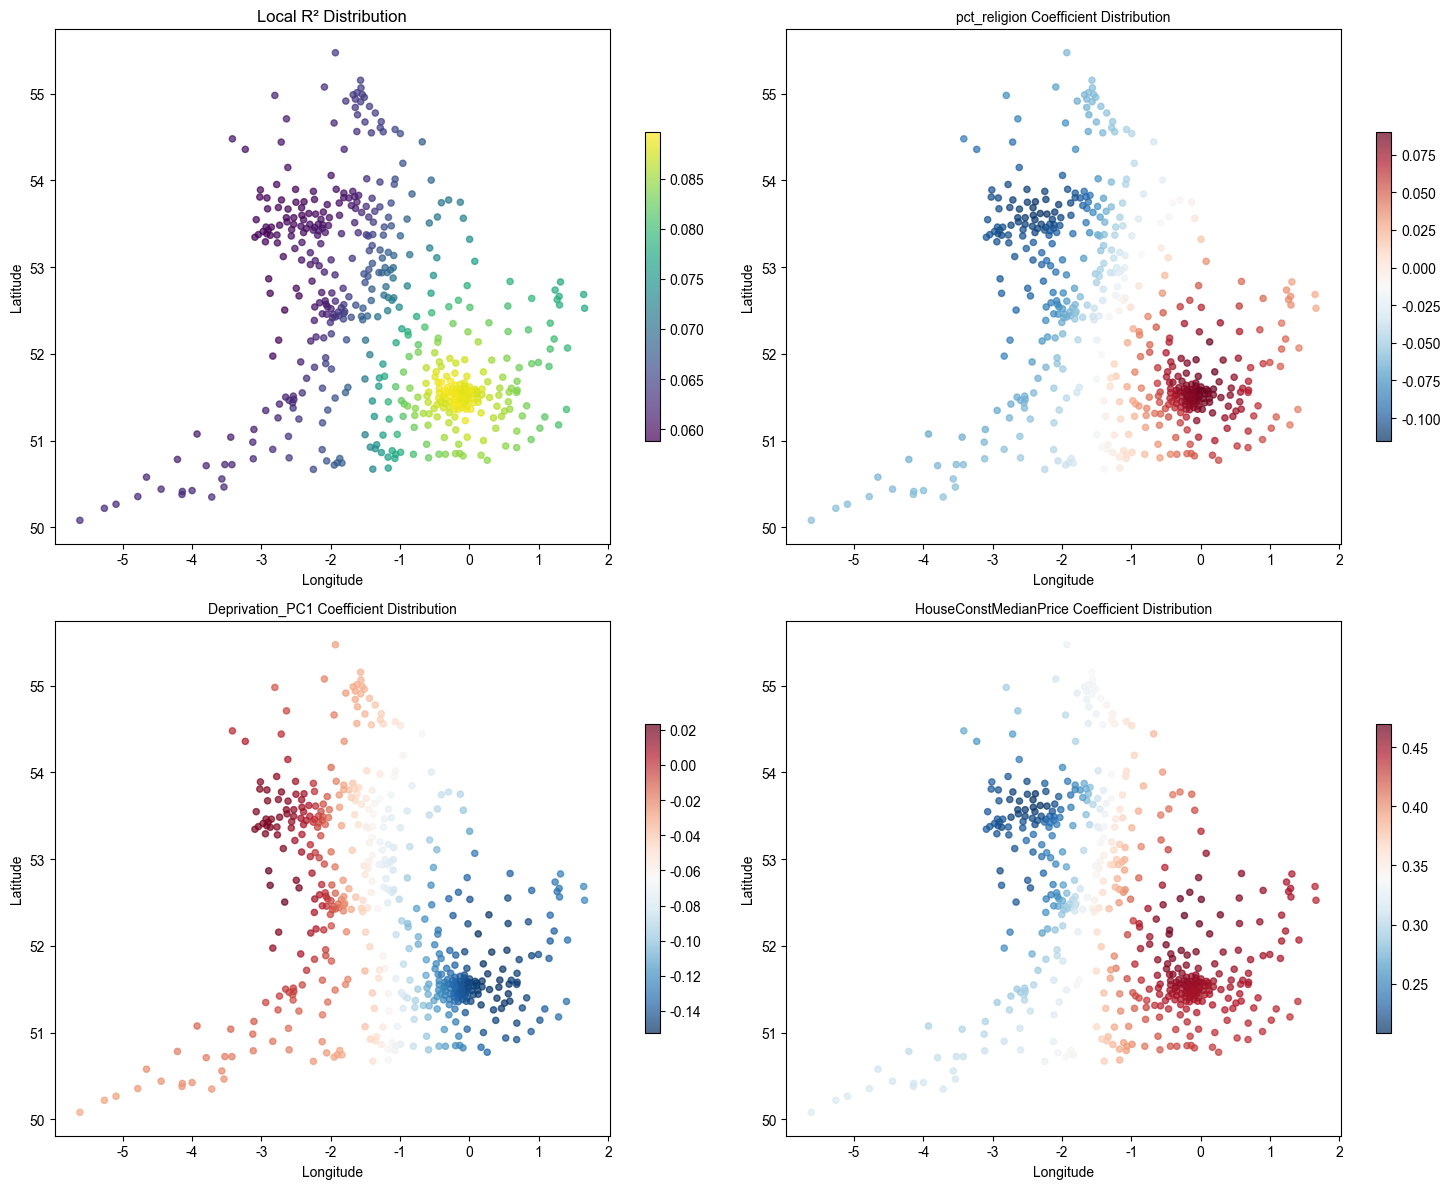

 Spatial coefficient map saved as 'gwr_spatial_coefficients.png'

 5.3 Residual Diagnostic Plots


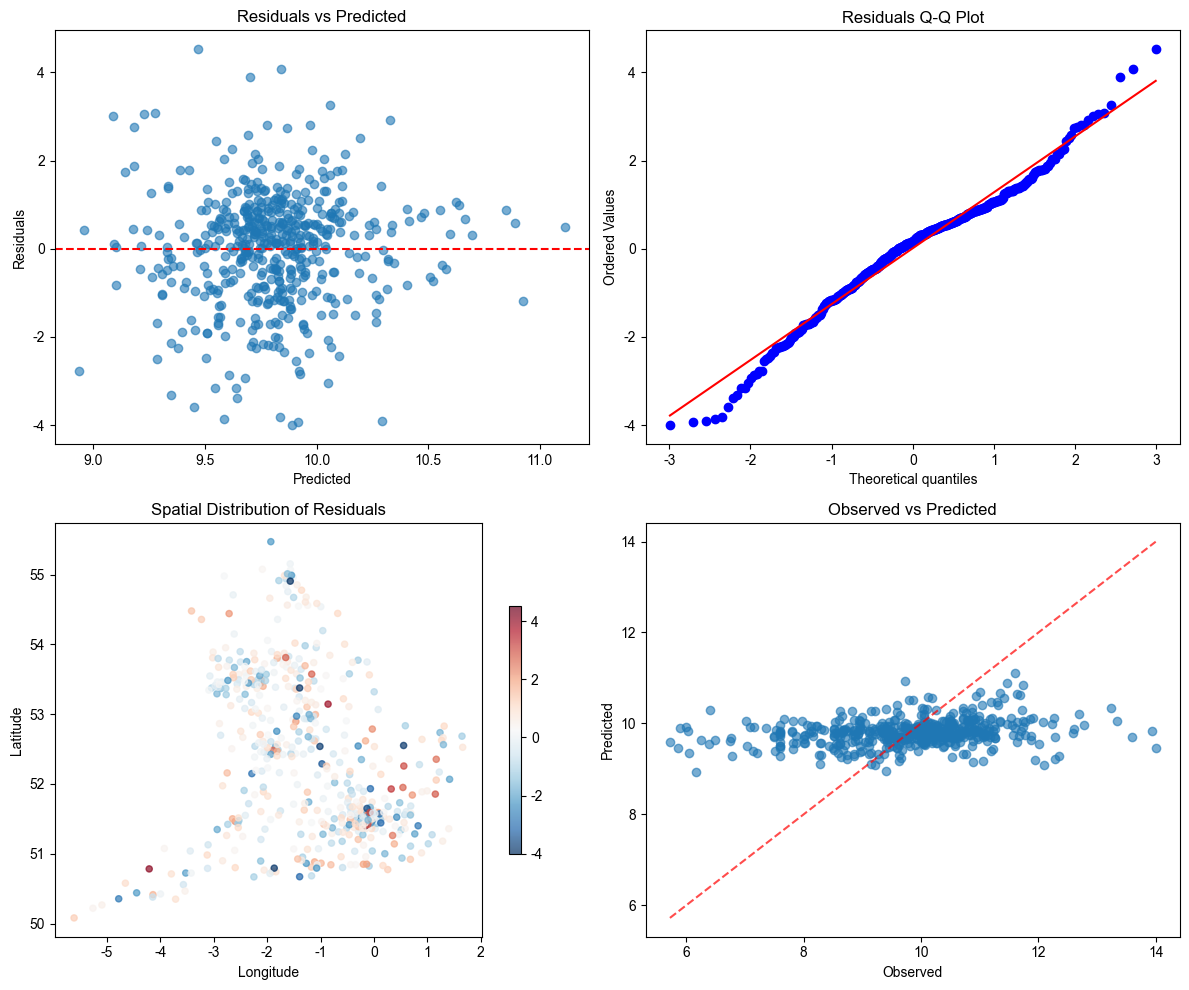

 Residual diagnostic plots saved as 'gwr_diagnostics.png'

 5.4 Saving GWR analysis results
 Full result saved as 'gwr_results_detailed.csv'
 Coefficient summary saved as 'gwr_coefficient_summary.csv'


In [ ]:
# GWR Result Visualization
print("\n GWR Result Visualization")
print("-" * 50)

if success:
    import matplotlib.pyplot as plt
    from scipy import stats

    # Optional: Set font to avoid Chinese warning if labels are still in Chinese
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.unicode_minus'] = False

    # 5.1 Create Result DataFrame
    print(" 5.1 Creating GWR result DataFrame")
    gwr_results_df = gwr_clean[['LAT', 'LONG']].copy()
    gwr_results_df['log_outside_payment'] = y
    gwr_results_df['predicted'] = gwr_results.predy.flatten()
    gwr_results_df['residuals'] = gwr_results.resid_response.flatten()
    gwr_results_df['local_R2'] = local_rsq

    for i, var_name in enumerate(variable_names):
        gwr_results_df[f'coeff_{var_name}'] = local_coeffs[:, i]

    print(f" GWR result DataFrame created, shape: {gwr_results_df.shape}")

    # 5.2 Coefficient Spatial Maps
    print("\n 5.2 Generating spatial distribution maps for local coefficients")
    key_vars_to_plot = ['pct_religion', 'Deprivation_PC1', 'HouseConstMedianPrice']
    available_plot_vars = [var for var in key_vars_to_plot if f'coeff_{var}' in gwr_results_df.columns]

    if available_plot_vars:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        # Plot local R²
        scatter = axes[0].scatter(gwr_results_df['LONG'], gwr_results_df['LAT'],
                                  c=gwr_results_df['local_R2'],
                                  cmap='viridis', s=20, alpha=0.7)
        axes[0].set_title('Local R² Distribution', fontsize=12)
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        plt.colorbar(scatter, ax=axes[0], shrink=0.6)

        # Plot local coefficients
        for i, var in enumerate(available_plot_vars[:3]):
            coeff_col = f'coeff_{var}'
            scatter = axes[i+1].scatter(gwr_results_df['LONG'], gwr_results_df['LAT'],
                                        c=gwr_results_df[coeff_col],
                                        cmap='RdBu_r', s=20, alpha=0.7)
            axes[i+1].set_title(f'{var} Coefficient Distribution', fontsize=10)
            axes[i+1].set_xlabel('Longitude')
            axes[i+1].set_ylabel('Latitude')
            plt.colorbar(scatter, ax=axes[i+1], shrink=0.6)

        plt.tight_layout()
        plt.savefig('gwr_spatial_coefficients.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(" Spatial coefficient map saved as 'gwr_spatial_coefficients.png'")

    # 5.3 Residual Diagnostics
    print("\n 5.3 Residual Diagnostic Plots")
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals vs Predicted
    axes[0, 0].scatter(gwr_results_df['predicted'], gwr_results_df['residuals'], alpha=0.6)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_title("Residuals vs Predicted")
    axes[0, 0].set_xlabel("Predicted")
    axes[0, 0].set_ylabel("Residuals")

    # Q-Q Plot
    stats.probplot(gwr_results_df['residuals'], dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title("Residuals Q-Q Plot")

    # Residuals Spatial Distribution
    scatter = axes[1, 0].scatter(gwr_results_df['LONG'], gwr_results_df['LAT'],
                                 c=gwr_results_df['residuals'], cmap='RdBu_r', s=20, alpha=0.7)
    axes[1, 0].set_title("Spatial Distribution of Residuals")
    axes[1, 0].set_xlabel("Longitude")
    axes[1, 0].set_ylabel("Latitude")
    plt.colorbar(scatter, ax=axes[1, 0], shrink=0.6)

    # Observed vs Predicted
    axes[1, 1].scatter(y, gwr_results_df['predicted'], alpha=0.6)
    axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', alpha=0.7)
    axes[1, 1].set_title("Observed vs Predicted")
    axes[1, 1].set_xlabel("Observed")
    axes[1, 1].set_ylabel("Predicted")

    plt.tight_layout()
    plt.savefig('gwr_diagnostics.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Residual diagnostic plots saved as 'gwr_diagnostics.png'")

    # 5.4 Save Results
    print("\n 5.4 Saving GWR analysis results")
    gwr_results_df.to_csv('gwr_results_detailed.csv', index=False)
    print(" Full result saved as 'gwr_results_detailed.csv'")

    coeff_summary = pd.DataFrame(coeff_stats).T
    coeff_summary.to_csv('gwr_coefficient_summary.csv')
    print(" Coefficient summary saved as 'gwr_coefficient_summary.csv'")

else:
    print(" Skipping visualization (GWR model estimation failed)")

In [893]:
# GWR Interpretation and Academic Application
print("\n GWR Interpretation and Academic Application")
print("-" * 50)
if success:
    print(" Summary of Main Findings")
    # Summary of key findings
    print("\n Key Findings:")
    print("─" * 40)
    print(f" Model Performance:")
    print(f"   • Average Local R²: {np.mean(local_rsq):.3f}")
    print(f"   • R² Range: {np.min(local_rsq):.3f} - {np.max(local_rsq):.3f}")
    print(f"   • AIC Improvement: {ols_model.aic - gwr_results.aic:.2f}")
    print(f"\n2. Spatial Heterogeneity:")
    print(f"   • Number of variables with significant spatial variation: {len(high_variation_vars)}")
    if high_variation_vars:
        print(f"   • Key heterogeneous variables: {', '.join(high_variation_vars[:3])}")
    print(f"\n3. Locality:")
    print(f"   • Optimal bandwidth: {optimal_bw:.0f} neighbors")
    print(f"   • ENP ratio (effective degrees of freedom): {enp_ratio:.3f}")
    print(f"\n Spatial Hypothesis Tests")
    print("─" * 40)
    # H0: Spatial variation in religion effect
    if 'pct_religion' in coeff_stats:
        religion_stats = coeff_stats['pct_religion']
        print(f"\nH0 (Religion → Sleaze relationship):")
        print(f"   • Mean effect: {religion_stats['mean']:.4f}")
        print(f"   • Coefficient of variation (CV): {religion_stats['cv']:.3f}")
        print(f"   • Effect range: [{religion_stats['min']:.4f}, {religion_stats['max']:.4f}]")

        if religion_stats['cv'] > 0.5:
            print(f"   Religion effect shows strong spatial heterogeneity")
        else:
            print(f"   Religion effect is relatively stable with minor spatial variation")

    # H1: Spatial variation in deprivation effect
    deprivation_vars = ['Deprivation_PC1', 'Deprivation_PC2']
    for dep_var in deprivation_vars:
        if dep_var in coeff_stats:
            dep_stats = coeff_stats[dep_var]
            print(f"\nH1 ({dep_var}):")
            print(f"   • Mean effect: {dep_stats['mean']:.4f}")
            print(f"   • Coefficient of variation (CV): {dep_stats['cv']:.3f}")
            print(f"   • Effect range: [{dep_stats['min']:.4f}, {dep_stats['max']:.4f}]")

            if dep_stats['cv'] > 0.5:
                print(f"   Deprivation effect shows strong spatial heterogeneity")
            else:
                print(f"   Deprivation effect is relatively stable across space")

    print(f"\n Data Quality Assessment")
    print("─" * 40)

    print("Data quality indicators:")
    print(f"• Sample completeness: {len(gwr_clean)/len(gwr_data)*100:.1f}%")
    print(f"• Spatial coverage: {len(gwr_clean)} UK constituencies")
    print(f"• Model stability (ENP ratio): {enp_ratio:.3f}")

    if enp_ratio < 0.3 and len(gwr_clean) > 200:
        print(" Data quality is good; GWR results are reliable")
    else:
        print(" Interpretation of GWR results should be cautious")


 GWR Interpretation and Academic Application
--------------------------------------------------
 Summary of Main Findings

 Key Findings:
────────────────────────────────────────
 Model Performance:
   • Average Local R²: 0.073
   • R² Range: 0.059 - 0.090
   • AIC Improvement: 2.81

2. Spatial Heterogeneity:
   • Number of variables with significant spatial variation: 7
   • Key heterogeneous variables: pct_religion, Deprivation_PC1, share_graduates

3. Locality:
   • Optimal bandwidth: 202 neighbors
   • ENP ratio (effective degrees of freedom): 0.034

 Spatial Hypothesis Tests
────────────────────────────────────────

H0 (Religion → Sleaze relationship):
   • Mean effect: -0.0114
   • Coefficient of variation (CV): 5.946
   • Effect range: [-0.1151, 0.0899]
   Religion effect shows strong spatial heterogeneity

H1 (Deprivation_PC1):
   • Mean effect: -0.0682
   • Coefficient of variation (CV): 0.833
   • Effect range: [-0.1525, 0.0232]
   Deprivation effect shows strong spatial het

## Mps dimension

- 'H4' :
- 'H5' :

In [ ]:
Mps_df = pd.read_csv("GE2024_results_with_three_categories.csv")
Mps_df['majority_decile'] = pd.qcut(df['Majority'], 10, labels=False, duplicates='drop')
decile_summary = Mps_df['majority_decile'].value_counts().sort_index()
print(decile_summary)

# Save the dataframe with the new majority_decile column
df.to_csv("GE2024_results_with_three_categories.csv", index=False)
print("CSV file updated with majority_decile column")